# Batik Classification

## 1. Exploratory Data Analysis

In [1]:
import os

In [11]:
train_data_dir = 'data/train/'
test_data_dir = 'data/test/'

In [12]:
# Iterate and count labels from dataset
def dataset_label_count(data_dir):
    label_counts = {}
    total_count = 0
    for label in os.listdir(data_dir):
        label_path = os.path.join(data_dir, label)
        if os.path.isdir(label_path):
            count = len([file for file in os.listdir(label_path) if file.endswith('.jpg')])
            label_counts[label] = count
            total_count += count
    for label, count in label_counts.items():
        print(f'Label: {label}, Number of images: {count}')
    print(f'Total number of images: {total_count}')

print("Train Data:")
dataset_label_count(train_data_dir)
print("\nTest Data:")
dataset_label_count(test_data_dir)

Train Data:
Label: Ceplok, Number of images: 157
Label: Kawung, Number of images: 560
Label: Lereng, Number of images: 51
Label: Megamendung, Number of images: 560
Label: Nitik, Number of images: 107
Label: Parang, Number of images: 560
Label: Truntum, Number of images: 560
Total number of images: 2555

Test Data:
Label: Ceplok, Number of images: 15
Label: Kawung, Number of images: 140
Label: Lereng, Number of images: 10
Label: Megamendung, Number of images: 150
Label: Nitik, Number of images: 10
Label: Parang, Number of images: 140
Label: Truntum, Number of images: 150
Total number of images: 615


## 2. Data Augmentation and Preprocessing

In [13]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [8]:
BATCH_SIZE = 32
IMAGE_SIZE = (256, 256)

In [14]:
# Augmentation
train_datagen = ImageDataGenerator(rescale=1.0/255,
                                   rotation_range=20,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1.0/255)

In [15]:
train_generator = train_datagen.flow_from_directory(train_data_dir,
                                               batch_size = BATCH_SIZE,
                                               target_size = IMAGE_SIZE,
                                               class_mode = "categorical",
                                               shuffle = True)

test_generator = train_datagen.flow_from_directory(test_data_dir,
                                               batch_size = BATCH_SIZE,
                                               target_size = IMAGE_SIZE,
                                               class_mode = "categorical",
                                               shuffle = False)

Found 2559 images belonging to 7 classes.
Found 615 images belonging to 7 classes.


## 3. Model Building

In [21]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models
from tensorflow.keras import regularizers
import matplotlib.pyplot as plt

In [9]:
vgg_base = VGG16(weights='imagenet', include_top=False, pooling='avg', input_shape=(256, 256, 3))
vgg_base.trainable = True

# Fine-tune the last 4 layers
for layer in vgg_base.layers[:-4]: 
    layer.trainable = False

model = models.Sequential([
    vgg_base,
    layers.Dense(4096, activation='tanh', input_shape=512, kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.6),
    layers.Dense(train_generator.num_classes, activation='softmax', kernel_initializer='uniform')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

c:\Users\Arleen\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 512)            │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4096)           │     2,101,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │        28,679 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,844,615 (64.26 MB)

 Trainable params: 6,849,543 (26.13 MB)

 Non-trainable params: 9,995,072 (38.13 MB)

## 4. Training

In [10]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=10,
    validation_data=test_generator,
    validation_steps=test_generator.samples // BATCH_SIZE
)

c:\Users\Arleen\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.6641 - loss: 1.6882

c:\Users\Arleen\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


79/79 ━━━━━━━━━━━━━━━━━━━━ 353s 4s/step - accuracy: 0.6659 - loss: 1.6805 - val_accuracy: 0.9589 - val_loss: 0.4340
Epoch 2/10
 1/79 ━━━━━━━━━━━━━━━━━━━━ 4:36 4s/step - accuracy: 0.9062 - loss: 0.5323

c:\Users\Arleen\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


79/79 ━━━━━━━━━━━━━━━━━━━━ 64s 776ms/step - accuracy: 0.9062 - loss: 0.5323 - val_accuracy: 0.9638 - val_loss: 0.4269
Epoch 3/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 484s 6s/step - accuracy: 0.9107 - loss: 0.5258 - val_accuracy: 0.9589 - val_loss: 0.3060
Epoch 4/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 63s 759ms/step - accuracy: 0.9688 - loss: 0.2809 - val_accuracy: 0.9622 - val_loss: 0.2978
Epoch 5/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 332s 4s/step - accuracy: 0.9078 - loss: 0.4095 - val_accuracy: 0.9145 - val_loss: 0.3363
Epoch 6/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 63s 764ms/step - accuracy: 0.9688 - loss: 0.2790 - val_accuracy: 0.9260 - val_loss: 0.3262
Epoch 7/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 341s 4s/step - accuracy: 0.9254 - loss: 0.3116 - val_accuracy: 0.9408 - val_loss: 0.3268
Epoch 8/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 62s 757ms/step - accuracy: 0.7500 - loss: 0.6881 - val_accuracy: 0.9441 - val_loss: 0.2916
Epoch 9/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 332s 4s/step - accuracy: 0.9311 - loss: 0.2543 - val_accuracy: 0.9720 - val_

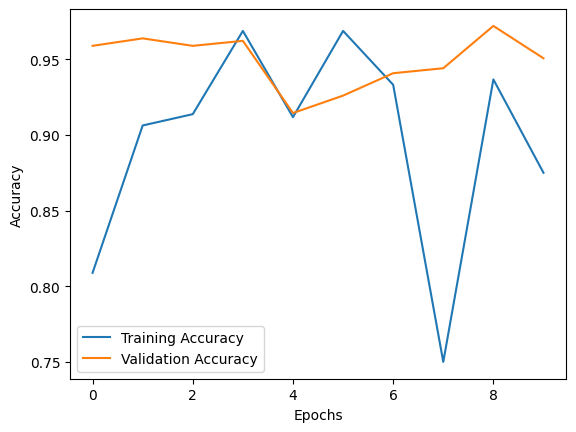

In [11]:
# Training Accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

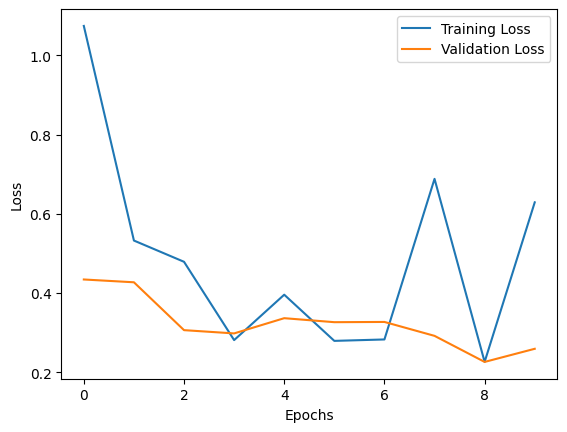

In [12]:
# Training Loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [13]:
# Save model
model.save('models/model.h5')
model.save_weights('models/model.weights.h5')

## 5. Predict

In [4]:
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model

In [5]:
# Load model
model = load_model('models/model.h5')

In [22]:
def predict_single_image(img_path):
    img = image.load_img(img_path, target_size=IMAGE_SIZE)
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    
    prediction = model.predict(img_array)
    predicted_class = train_generator.class_indices
    class_label = {v: k for k, v in predicted_class.items()}
    predicted_label = class_label[np.argmax(prediction)]

    # Display the image
    plt.imshow(image.load_img(img_path))
    plt.axis('off')
    plt.title(f"Predicted Label: {predicted_label}")
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


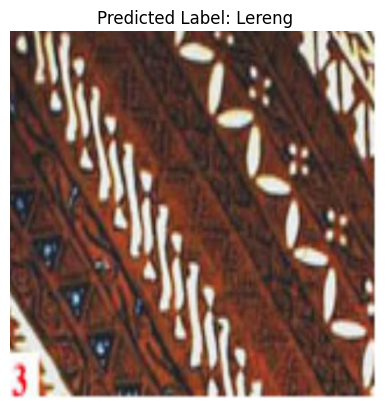

In [63]:
predict_single_image('data/test/Lereng/YK074.jpg')

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 717ms/step


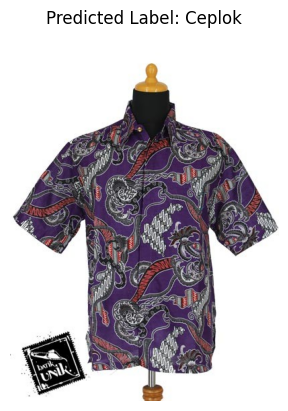

In [46]:
predict_single_image('data/test/Ceplok/26.jpg')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step


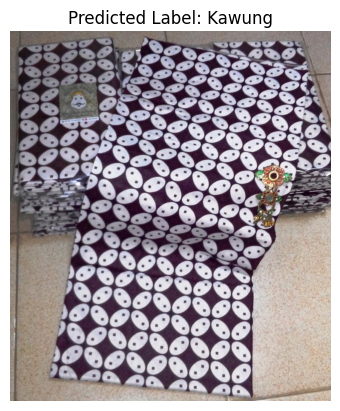

In [ ]:
predict_single_image('data/test/Kawung/11.jpg')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


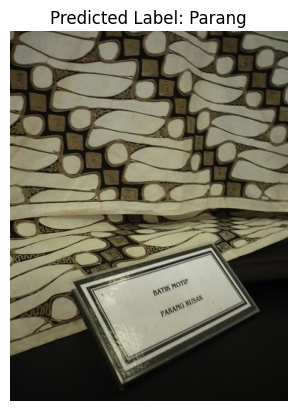

In [60]:
predict_single_image('data/test/Parang/38 (2).jpg')

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 645ms/step


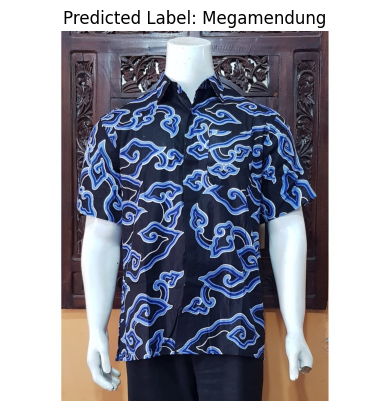

In [62]:
predict_single_image('data/test/Megamendung/1.jpeg')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step


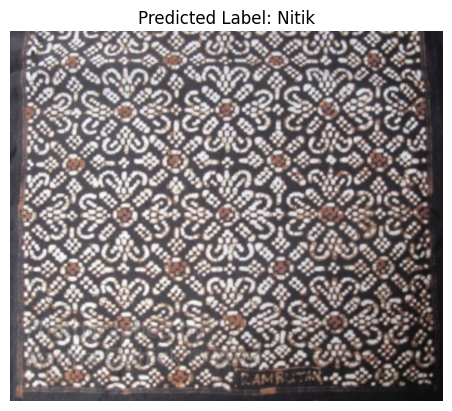

In [72]:
predict_single_image('data/test/Nitik/0.png')

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 644ms/step


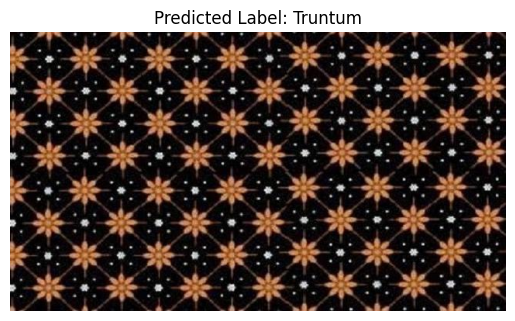

In [77]:
predict_single_image('data/test/Truntum/0.jpg')

## 5. Evaluate

In [17]:
from sklearn.metrics import classification_report

In [18]:
Y_pred = model.predict(test_generator, test_generator.samples // test_generator.batch_size + 1)
y_pred = np.argmax(Y_pred, axis=1)

20/20 ━━━━━━━━━━━━━━━━━━━━ 66s 3s/step


In [19]:
print('Classification Report')
print(classification_report(test_generator.classes, y_pred, target_names=test_generator.class_indices.keys()))

Classification Report
              precision    recall  f1-score   support

      Ceplok       0.65      0.73      0.69        15
      Kawung       0.99      1.00      1.00       140
      Lereng       0.50      0.10      0.17        10
 Megamendung       1.00      1.00      1.00       150
       Nitik       0.25      0.60      0.35        10
      Parang       0.98      0.99      0.98       140
     Truntum       0.98      0.91      0.94       150

    accuracy                           0.95       615
   macro avg       0.76      0.76      0.73       615
weighted avg       0.96      0.95      0.95       615

